In [969]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm, tnrange
from tqdm.notebook import trange
from sklearn.metrics import roc_auc_score

In [20]:
np.random.choice(np.arange(20), size=20, replace=True)

array([ 4, 10,  2, 17, 10,  2,  2, 10, 19,  9,  9, 12,  5,  4,  1, 11,  7,
       16,  8, 10])

In [899]:
class RandomForest:
    def __init__(self, trees=1000, max_depth=7, alpha=1.0, beta=None, bootstrap=True, decision='avg'):
        self.trees = trees
        self.max_depth = max_depth
        self.alpha = alpha
        self.beta = beta
        self.bootstrap = bootstrap
        self.decision = decision
        self._tree_array = []
        
    def fit(self, X, y):
        for _ in tnrange(self.trees):
            tree = DecisionTree(X, y, alpha=self.alpha, beta=self.beta, bootstrap=self.bootstrap, 
                                decision=self.decision, max_depth=self.max_depth)
            self._tree_array.append(tree)
    
    def predict(self, x):
        out = np.empty((self.trees))
        for i in range(self.trees):
            out[i] = self._tree_array[i].predict(x)
        return sum(out) / len(out)

In [900]:
class DecisionTree:
    def __init__(self, X, y=None, alpha=1.0, beta=None, bootstrap=True, decision='avg', max_depth=20):
        if len(X.shape) != 2:
            raise AttributeError("X must have shape equal to 2")
        n_samples = X.shape[0]
        n_features = X.shape[1]
        if beta is None:
            beta = 1.0 / np.sqrt(n_features)
        cf = self._choose_features(n_features, int(n_features * beta))
        cs = self._choose_samples(n_samples, int(n_samples * alpha), bootstrap=bootstrap)
        X_choice = X[cs, :][:, cf]
        y_choice = None
        if not y is None:
            y_choice = y[cs]
        self.root = TreeNode(max_depth=max_depth, decision=decision)
        self.root.fit(X_choice, y_choice)
    
    def _choose_features(self, n_features, target_n_features):
        choice = np.random.choice(np.arange(n_features), size=target_n_features, replace=False)
        return choice
    
    def _choose_samples(self, n_samples, target_n_samples=None, bootstrap=True):
        if target_n_samples is None:
            target_n_samples = n_samples
        if bootstrap == True:
            if target_n_samples != n_samples:
                raise AttributeError("Target samples number should be equal to the dataset size when bootstrap==True")
        choice = np.random.choice(np.arange(n_samples), size=target_n_samples, replace=bootstrap)
        return choice
    
    def predict(self, x):
        return self.root.predict(x)

In [929]:
class TreeNode:
    def __init__(self, depth=0, max_depth=20, decision='avg'):
        """
        decision in ('avg', 'grid')
        """
        self.left = None
        self.right = None
        self.feature = None
        self.cut = None
        self.depth = depth
        self.max_depth = max_depth
        self.decision = decision
        self.prediction = None
        
    def fit(self, X, y):
        if y is None:
             raise AttributeError("Can't fit without ground truth data")
        if self.depth < self.max_depth and X.shape[0] > 1 and np.unique(y).shape[0] > 1:
            grid = self._init_grid(X, y)
            min_loss = math.inf
            min_args = None
            for f_ind, values in grid.items():
                for cut in values:
                    loss_val = self.loss(X, y, f_ind, cut)
                    if loss_val < min_loss:
                        min_loss = loss_val
                        min_args = (f_ind, cut)
            if min_loss < math.inf:
                self.feature = min_args[0]
                self.cut = min_args[1]
                self.create_children(X, y)
            else:
                c = y[y == 1.0].sum()
                self.prediction = c.astype(np.float) / y.shape[0]
        else:
            if np.unique(y).shape[0] == 0:
                print("[WARNING] No values for y")
            c = y[y == 1.0].sum()
            self.prediction = c.astype(np.float) / y.shape[0]
        
    def _init_grid(self, X, y):
        UNIQUE = 10
        n_features = X.shape[1]
        grid = {}
        for f_num in range(n_features):
            feature = X[:, f_num]
            if self.decision == 'grid':
                f_min = feature.min()
                f_max = feature.max()
                f_unique = sorted(np.unique(feature))
                if len(f_unique) <= UNIQUE:
                    vals = [(f_unique[i] + f_unique[i+1]) / 2.0 for i in range(len(f_unique) - 1)]
                    grid[f_num] = vals
                else:
                    grid[f_num] = np.arange(f_min, f_max, (f_max - f_min) / UNIQUE)[1:]
            elif self.decision == 'avg':
                grid[f_num] = [(feature.max() - feature.min()) / 2.0]
        return grid
        
    def loss(self, X, y, feature, cut):
        mask = X[:, feature] < cut
        y_left = y[mask]
        y_right = y[~mask]
        if mask.sum() == 0 or (~mask).sum() == 0:
#             print(X.shape, feature, cut)
            return math.inf
        share_left = float(mask.sum()) / float(X.shape[0])
        share_right = float((~mask).sum()) / float(X.shape[0])
        
        _, y_left_counts = np.unique(y_left, return_counts=True)
        _, y_right_counts = np.unique(y_right, return_counts=True)
        part_left = y_left_counts / float(y_left.shape[0])
        part_right = y_right_counts / float(y_right.shape[0])
        entr_left = 1.0 - part_left.dot(part_left)
        entr_right = 1.0 - part_right.dot(part_right)
        return share_left * entr_left + share_right * entr_right
    
    def create_children(self, X, y):
        mask = X[:, self.feature] < self.cut
        X_left = X[mask, :]
        X_right = X[~mask, :]
        y_left = y[mask]
        y_right = y[~mask]
        self.left = TreeNode(self.depth + 1, decision=self.decision, max_depth=self.max_depth)
        self.left.fit(X_left, y_left)
        self.right = TreeNode(self.depth + 1, decision=self.decision, max_depth=self.max_depth)
        self.right.fit(X_right, y_right)
    
    def predict(self, x):
        if self.prediction is None:
            mask = x[self.feature] < self.cut
            if mask:
                pred = self.left.predict(x)
            else:
                pred = self.right.predict(x)
        else:
            pred = self.prediction
            
        return pred        

In [846]:
b = DecisionTree(X_train, y_train, beta=1.0)

In [581]:
out_test = np.empty(y_test.shape)
for i in range(X_test.shape[0]):
    out_test[i] = b.predict(X_test[i])

In [582]:
out_train = np.empty(y_train.shape)
for i in range(X_train.shape[0]):
    out_train[i] = b.predict(X_train[i])

In [583]:
def accuracy(y, out):
    return (y == out).sum() / y.shape[0]

In [584]:
accuracy(y_test, out_test)

0.5398773006134969

In [585]:
accuracy(y_train, out_train)

0.5446

In [883]:
np.arange(3, 18, (18.0 - 3.0) / 10.0)[1:]

array([ 4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. , 16.5])

In [961]:
f = RandomForest(decision='grid', trees=100, max_depth = 1000)

In [962]:
f.fit(X_train, y_train)

/Users/matsuk/anaconda3/envs/mds/lib/python3.6/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  if sys.path[0] == '':


  0%|          | 0/100 [00:00<?, ?it/s]

In [963]:
out_train = np.empty(y_train.shape)
for i in tnrange(X_train.shape[0]):
    out_train[i] = f.predict(X_train[i])

/Users/matsuk/anaconda3/envs/mds/lib/python3.6/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  


  0%|          | 0/10000 [00:00<?, ?it/s]

In [964]:
out_test = np.empty(y_test.shape)
for i in tnrange(X_test.shape[0]):
    out_test[i] = f.predict(X_test[i])

/Users/matsuk/anaconda3/envs/mds/lib/python3.6/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  


  0%|          | 0/3912 [00:00<?, ?it/s]

In [906]:
accuracy(y_test, out_test)

0.0

In [907]:
accuracy(y_train, out_train)

0.0

In [965]:
roc_value = roc_auc_score(y_test, out_test)
roc_value

0.7036098024449771

In [966]:
roc_value = roc_auc_score(y_train, out_train)
roc_value

0.6979674020819828

In [970]:
auc = []
for i in range(10):
    tr_mask = np.zeros(df.shape[0], dtype=bool)
    tr_mask[:tr_n] = True
    np.random.shuffle(tr_mask)

    X_data = df.drop(df.columns[[0]], axis=1).to_numpy()
    y_data = df['AH'].to_numpy()
    tr_n = 10000

    X_train = X_data[tr_mask]
    y_train = y_data[tr_mask]
    X_test = X_data[~tr_mask]
    y_test = y_data[~tr_mask]
    f = RandomForest(decision='grid', trees=100, max_depth = 1000)
    f.fit(X_train, y_train)
    
    out_train = np.empty(y_train.shape)
    for i in trange(X_train.shape[0]):
        out_train[i] = f.predict(X_train[i])

    out_test = np.empty(y_test.shape)
    for i in trange(X_test.shape[0]):
        out_test[i] = f.predict(X_test[i])

    roc_value_test = roc_auc_score(y_test, out_test)
    print(roc_value_test)
    roc_value_train = roc_auc_score(y_train, out_train)
    print(roc_value_train)
    auc.append((roc_value_test, roc_value_train))

/Users/matsuk/anaconda3/envs/mds/lib/python3.6/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  if sys.path[0] == '':


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/3912 [00:00<?, ?it/s]

0.7093692627458524
0.722830906577804


/Users/matsuk/anaconda3/envs/mds/lib/python3.6/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  if sys.path[0] == '':


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/3912 [00:00<?, ?it/s]

0.7138893137904752
0.715101103639731


/Users/matsuk/anaconda3/envs/mds/lib/python3.6/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  if sys.path[0] == '':


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/3912 [00:00<?, ?it/s]

0.7025415233980378
0.7315226192571731


/Users/matsuk/anaconda3/envs/mds/lib/python3.6/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  if sys.path[0] == '':


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/3912 [00:00<?, ?it/s]

0.6680485773641197
0.6640171846186462


/Users/matsuk/anaconda3/envs/mds/lib/python3.6/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  if sys.path[0] == '':


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/3912 [00:00<?, ?it/s]

0.7177366150590517
0.7191495336035989


/Users/matsuk/anaconda3/envs/mds/lib/python3.6/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  if sys.path[0] == '':


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/3912 [00:00<?, ?it/s]

0.7078532684836294
0.7072805916432602


/Users/matsuk/anaconda3/envs/mds/lib/python3.6/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  if sys.path[0] == '':


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/3912 [00:00<?, ?it/s]

0.6548001151936622
0.6771570940886434


/Users/matsuk/anaconda3/envs/mds/lib/python3.6/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  if sys.path[0] == '':


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/3912 [00:00<?, ?it/s]

0.7013903811619463
0.7005818883724086


/Users/matsuk/anaconda3/envs/mds/lib/python3.6/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  if sys.path[0] == '':


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/3912 [00:00<?, ?it/s]

0.6671562639872499
0.6591589355433103


/Users/matsuk/anaconda3/envs/mds/lib/python3.6/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  if sys.path[0] == '':


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/3912 [00:00<?, ?it/s]

0.6751452012908645
0.69682545485848


In [979]:
print(auc)

[(0.7093692627458524, 0.722830906577804), (0.7138893137904752, 0.715101103639731), (0.7025415233980378, 0.7315226192571731), (0.6680485773641197, 0.6640171846186462), (0.7177366150590517, 0.7191495336035989), (0.7078532684836294, 0.7072805916432602), (0.6548001151936622, 0.6771570940886434), (0.7013903811619463, 0.7005818883724086), (0.6671562639872499, 0.6591589355433103), (0.6751452012908645, 0.69682545485848)]


In [978]:
print(sum([x[0] for x in auc]) / len(auc))
print(sum([x[1] for x in auc]) / len(auc))

0.691793052247489
0.6993625312203056


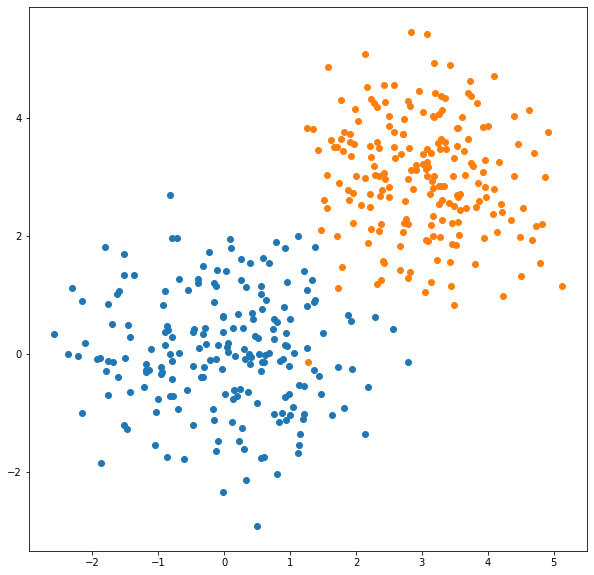

In [455]:
r1 = np.random.normal(size=(200, 2))
y1 = np.zeros((200))
fig = plt.figure(figsize=(10,10))
plt.scatter(r1[:,0], r1[:,1])
r2 = np.random.normal(size=(200, 2)) + 3
y2 = np.ones((200))
plt.scatter(r2[:,0], r2[:,1])
r = np.concatenate((r1, r2))
y = np.concatenate((y1, y2))

In [495]:
rtest1 = np.random.normal(size=(100, 2))
rtest2 = np.random.normal(size=(100, 2)) + 3
ytest1 = np.zeros((100))
ytest2 = np.ones((100))
rtest = np.concatenate((rtest1, rtest2))
ytest = np.concatenate((ytest1, ytest2))

In [449]:
df = pd.DataFrame(r)

In [450]:
df

,0,1
0,1.751493,0.093735
1,0.294413,-0.277744
2,0.625078,0.449235
3,0.195692,-1.641908
4,-1.577082,-0.212227
...,...,...
395,3.593105,2.889539
396,2.360729,2.567724
397,2.508296,3.810748
398,3.972253,2.071025


In [955]:
df = pd.read_csv('df_21jan.csv', delimiter=';', decimal=',')

In [956]:
df

,AH,SEX,AGE,LDL,HDL,WAI,BMI.10,ANX,DEPR,HR,...,region_20,region_53,region_69,region_4,region_5,region_18,SMN_3,SMN_2,EDUC_1,EDUC_0
0,1,0.74713,1.08456,2.48985,-0.47182,0.24487,0.30176,-0.06282,0.50885,-0.25851,...,-0.32835,-0.327,-0.31253,3.25462,-0.30695,-0.25636,-0.53022,-0.43713,-1.03911,-0.21118
1,1,0.74713,-1.06858,3.30617,1.27597,0.80793,1.75990,1.49790,0.77975,-0.06365,...,-0.32835,-0.327,-0.31253,3.25462,-0.30695,-0.25636,-0.53022,-0.43713,-1.03911,-0.21118
2,1,0.74713,1.34294,0.09006,-0.04897,1.40410,1.67655,0.45742,0.77975,-0.25851,...,-0.32835,-0.327,-0.31253,3.25462,-0.30695,-0.25636,-0.53022,-0.43713,-1.03911,-0.21118
3,1,-1.33836,0.13718,1.27028,-0.10535,0.34424,-0.06318,-1.62355,-0.03297,-0.64823,...,-0.32835,-0.327,-0.31253,3.25462,-0.30695,-0.25636,1.88589,-0.43713,0.96229,-0.21118
4,0,0.74713,-0.46570,-0.62791,1.36054,-0.58315,-0.94113,-0.58306,-1.11660,0.52092,...,-0.32835,-0.327,-0.31253,3.25462,-0.30695,-0.25636,-0.53022,-0.43713,0.96229,-0.21118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13907,1,0.74713,1.34294,0.97523,-0.04897,0.67544,1.19590,-0.84319,-0.84569,-0.55080,...,-0.32835,-0.327,3.19949,-0.30723,-0.30695,-0.25636,-0.53022,-0.43713,-1.03911,-0.21118
13908,0,-1.33836,-1.67146,-0.86396,0.14836,-0.78187,-1.17337,-0.84319,-0.84569,-0.25851,...,-0.32835,-0.327,3.19949,-0.30723,-0.30695,-0.25636,-0.53022,-0.43713,-1.03911,-0.21118
13909,1,0.74713,0.22331,0.87688,-0.13354,-0.64939,-0.85860,-0.58306,0.23794,0.52092,...,-0.32835,-0.327,3.19949,-0.30723,-0.30695,-0.25636,-0.53022,2.28749,-1.03911,-0.21118
13910,1,-1.33836,-0.81020,-1.42456,-1.57123,-0.05321,-0.95813,-1.62355,-0.57478,0.03378,...,-0.32835,-0.327,3.19949,-0.30723,-0.30695,-0.25636,1.88589,-0.43713,-1.03911,-0.21118


In [689]:
df = df.drop(df[['region_90', 'region_24', 'region_71', 'region_32', 'region_20','region_53', 'region_69', 'region_4', 'region_5', 'region_18', 'SMN_3','SMN_2', 'EDUC_1', 'EDUC_0']], axis=1)

In [957]:
X_data = df.drop(df.columns[[0]], axis=1).to_numpy()

In [958]:
y_data = df['AH'].to_numpy()

In [959]:
tr_n = 10000
X_train = X_data[:tr_n]
y_train = y_data[:tr_n]
X_test = X_data[tr_n:]
y_test = y_data[tr_n:]

In [960]:
X_train.shape

(10000, 30)

In [937]:
X = np.empty((20, 5))
for i in range(20):
    X[i, 0] = i % 2
    X[i, 1] = 1.0 / 20 * i
    X[i, 2] = i
    X[i, 3] = 1.0 / 20 * (20 - i)
    X[i, 4] = i % 5

In [938]:
pd.DataFrame(X)

,0,1,2,3,4
0,0.0,0.00,0.0,1.00,0.0
1,1.0,0.05,1.0,0.95,1.0
2,0.0,0.10,2.0,0.90,2.0
3,1.0,0.15,3.0,0.85,3.0
4,0.0,0.20,4.0,0.80,4.0
5,1.0,0.25,5.0,0.75,0.0
6,0.0,0.30,6.0,0.70,1.0
7,1.0,0.35,7.0,0.65,2.0
8,0.0,0.40,8.0,0.60,3.0
9,1.0,0.45,9.0,0.55,4.0


$$\int_{sh\ 1}^{sh\ 2}\frac{dx}{\sqrt{1+x^2}}$$